TP1 Introduction à [PyTorch](https://pytorch.org/)
==========================



Made by DI SANTO Alexandre and ROYER Julia.

In [36]:
import numpy as np
import torch
import matplotlib.pyplot as plt
np.random.seed(42)

# **1**. chargement et affichage des données

In [37]:
# data loading
data = np.loadtxt('dataset.csv')
print('shape =', data.shape)
print('size  =', data.size)
print('dtype =', data.dtype)

shape = (3200, 2)
size  = 6400
dtype = float64


Text(0.5, 1.0, 'Input data')

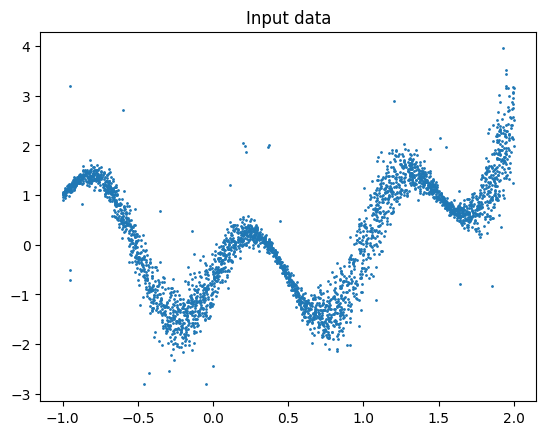

In [38]:
# data plot
plt.figure()
plt.scatter(data[:,0], data[:,1], s=1.0)
plt.title('Input data')

# **2**. Normalisation des données

Centrer et réduire les échantillons $\lbrace x_i, y_i \rbrace_{i=1\ldots N}$ en soustrayant la moyenne et en divisant par l'écart type calculés indépendamment pour $\mathcal{X}$ et pour $\mathcal{Y}$.

Utiliser 
[`np.mean`](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) et 
[`np.std`](https://numpy.org/doc/stable/reference/generated/numpy.std.html) 
en faisant attention au paramètre `axis`.

In [39]:
# ... to do

col_means = np.mean(data, axis=0)
data = (data - col_means) / np.std(data, axis=0)


Text(0.5, 1.0, 'Normalized data')

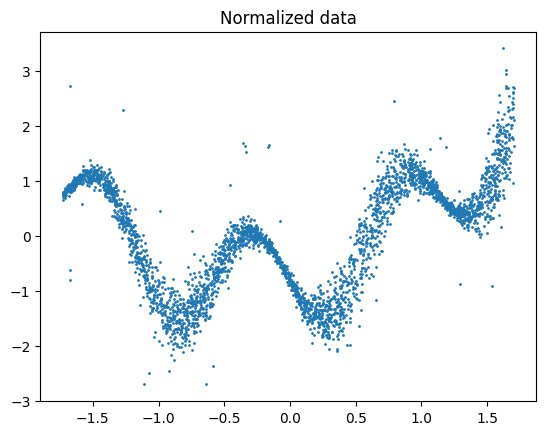

In [40]:
# normalized data plot
plt.scatter(data[:,0], data[:,1], s=1.0)
plt.title('Normalized data')

# **3**. Donné d'entraînement et données de test

Diviser les `data` en deux nouvelles variables `data_train` et `data_test` dont les tailles sont fixées par un ratio $70/30$.

La division des données doit être **aléatoire**. Utiliser la fonction [`np.random.permutation`](https://numpy.org/doc/2.0/reference/random/generated/numpy.random.permutation.html) pour générer une permutation aléatoire de $N$ indices entre $0$ et $N-1$.


In [41]:
ratio = 0.70
rand_data = np.random.permutation(data)

limit_train = int(len(rand_data)*ratio)
# ...
data_train = rand_data[0:limit_train-1] # ...
data_test = rand_data[limit_train:] # ...

Text(0.5, 1.0, 'Train and test data')

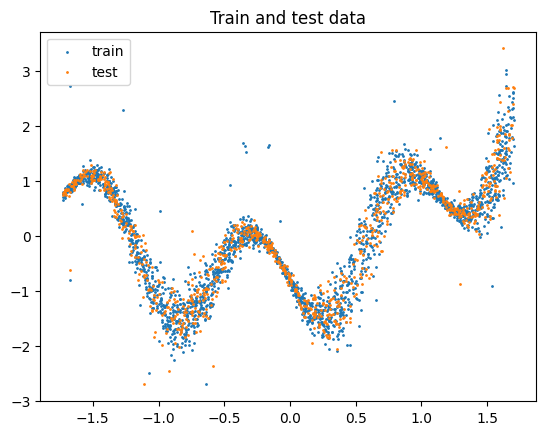

In [42]:
# plot train and test data
plt.figure()
plt.scatter(data_train[:,0], data_train[:,1], label='train', s=1.0)
plt.scatter(data_test[:,0], data_test[:,1], label='test', s=1.0)
plt.legend()
plt.title('Train and test data')

# **4**. Création de DataSet et de DataLoader

Compléter la classe `DataSet` qui hérite de la classe [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) qui propose une interface de type '_map_' (en opposition au [`torch.utils.data.IterableDataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset) qui propose une interface de type '_iterable_') :
- `self.data` correspond à `data_train` ou `data_test`, soit un tableau Numpy de taille $M\times 2$
- `DataSet.__len__` retourne le nombre d'éléments
- `DataSet.__getitem__` retourne une paire $\lbrace x_i, y_i\rbrace$ de 2 nombres flottants correspondants au $i$-ème exemple

In [43]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self, data: np.ndarray) -> None:
        self.data = data
    def __len__(self) -> int:
        # ...
        return self.data.shape[0]
    def __getitem__(self, i: int):
        # ...
        return data[i,:]

##### test Dataset

In [44]:
# data_to_test = DataSet(data)
# assert len(data_to_test) == data.shape[0]
# assert data_to_test[0].all() == data[0,:].all()

Créer les deux datasets `dataset_train` et `dataset_test` à partir des données `data_train` et `data_test`, puis créer deux [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) avec 
- `batch_size` égal à `16` (taille de _'mini'-batch_)
- `shuffle` égal à `True` (les données sont aléatoirement réordonnées à chaque début d'époque)

In [45]:
# ...

dataset_train = DataSet(data_train) # ...
dataset_test = DataSet(data_test) # ...

batch_size = 16

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True) # ...
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True) # ...


Afficher les $3$ premiers batches du dataloader d'entraînement.

Text(0.5, 1.0, '3 first (random) training batches of size 16')

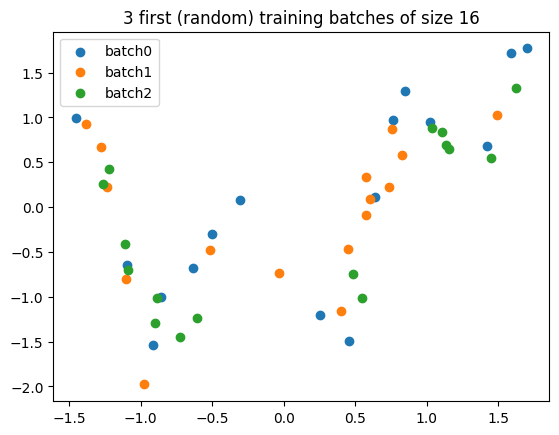

In [46]:
plt.figure()

# ...
batch_0 = next(iter(dataloader_train))
batch_1 = next(iter(dataloader_train))
batch_2 = next(iter(dataloader_train))
plt.scatter(batch_0[:,0], batch_0[:,1], label='batch0')
plt.scatter(batch_1[:,0], batch_1[:,1], label='batch1')
plt.scatter(batch_2[:,0], batch_2[:,1], label='batch2')
plt.legend()

plt.title(f'3 first (random) training batches of size {batch_size}')


# **5**. Création du réseau de neurones

Compléter la classe `NeuralNet` qui hérite de la classe [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#module).

Dans le constructeur `__init__`, insérer des couches grâce à la fonction `append` de `torch.nn.Sequential`.
Chaque _layer_ est une combinaison d'une couche linéaire (`torch.nn.Linear`) et d'une fonction d'activation non-linéaire (`torch.nn.ReLU`), **sauf** la dernière couche qui ne contient qu'une couche linéaire.
- la première couche a une dimension `in_features` égale à `dim_input`, c'est-à-dire $1$ (la dimension de $\mathcal{X}$).
- la dernière couche a une dimension `out_features` égale à `dim_output`, c'est-à-dire $1$ (la dimension de $\mathcal{Y}$).
- les couches cachées ont des dimensions définies par la liste `dim_hidden`

Le fonction `forward` effectue une passe 'en avant' du réseau en l'appliquant aux données d'entrées `x`. Il suffit d'appeler l'opérateur `()` de `self.layers` pour que chaque couche soit appelée une à une. Dans ce TP, `x` est de taille `batch_size x 1`.

In [47]:

class NeuralNet(torch.nn.Module):
    def __init__(self, dim_input=1, dim_output=1, dim_hidden=[16]):
        super(NeuralNet, self).__init__()
        self.layers = torch.nn.Sequential()
        # 1st layer
        # ...
        self.layers.append(torch.nn.Linear(in_features=dim_input, out_features=dim_hidden[0], bias=True))

        # hidden layers
        # ...
        for i in range(len(dim_hidden)):
            self.layers.append(torch.nn.ReLU())
            if i + 1 >= len(dim_hidden):
                last = dim_output
            else:
                last = dim_hidden[i+1]
            self.layers.append(torch.nn.Linear(in_features=dim_hidden[i], out_features=last, bias=True))


        # last layer
        # ...
        

    def forward(self, x):
        # ...
        return self.layers(x)


Afficher le détail de chaque couche en parcourant les paramètres du modèles avec la fonction `named_parameters` de `torch.nn.Module`.

Sommer le nombre de poids de chaque couche et afficher le nombre total de poids. 

In [48]:
dim_hidden = [16, 16]
model = NeuralNet(dim_hidden=dim_hidden)
print(model)

n_weights = 0
# ...
for a in model.named_parameters():
    print(a[0], a[1].shape)
    if len(a[1].shape) == 2:
        n_weights += a[1].shape[0]*a[1].shape[1]
    else:
        n_weights += a[1].shape[0]

print('Total number of weights =', n_weights)

NeuralNet(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)
layers.0.weight torch.Size([16, 1])
layers.0.bias torch.Size([16])
layers.2.weight torch.Size([16, 16])
layers.2.bias torch.Size([16])
layers.4.weight torch.Size([1, 16])
layers.4.bias torch.Size([1])
Total number of weights = 321


# **6**. Préparation de l'entraînement

Instancier le critère d'optimisation `criterion`, en choisisant une fonction de _loss_ adaptée au problème de regression parmi [les loss disponibles dans Pytorch](https://pytorch.org/docs/stable/nn.html#loss-functions).

Instancier l'`optimizer`, qui est responsable de la descente de gradient et de la mise-à-jour des paramètres du modèle, en choisisant l'algorithme d'optimisation adapté parmi [les algorithmes disponibles dans PyTorch](https://pytorch.org/docs/stable/optim.html#algorithms).

L'`optimizer` doit pouvoir être initialisé avec les paramètres du modèle (cf fonction `torch.nn.Module.parameters`) et un pas d'apprentissage (_learning rate_) `lr = 0.1`. 

In [49]:
criterion = torch.nn.MSELoss() # ...

lr = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=lr) # ...

# **7**. Entraînement

Compléter la boucle d'entraînement.

#### 1. extract (x,y)

- `x` et `y` doivent avoir une dimension de `batch_size x 1` (utiliser `torch.Tensor.unsqueeze` si besoins)
- le type doit être `torch.float` (utiliser `torch.Tensor.to` si besoins) 

#### 2. reset gradients to 0 using [`torch.optim.Optimizer.zero_grad`](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html)

#### 3. perform prediction 

- simple appel à l'opérateur `()` du modèle (qui appelle `forward` du modèle)

#### 4. compute loss using the criterion, y_pred, and y (ground truth)

- simple appel à l'opérateur `()` du critère

#### 5. compute gradient using [`torch.Tensor.backward`](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html) on the result of the loss

- attention: le critère `criterion` retourne un `torch.Tensor` (de taille `1` soit juste une valeurs) qui permet de démarrer la rétropropagation des gradients
- utiliser [`torch.Tensor.item`](https://pytorch.org/docs/stable/generated/torch.Tensor.item.html) pour récupérer la valeur de la loss dans un `float`

#### 6. update weights using one step of gradient descent with [`torch.optim.Optimizer.step`](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html)

#### 7. every `K` iterations

- perform one evaluation on the test dataloader
- store test loss and training loss averaged over the `K` last iterations

Le critère de la loss est utilisé ici, mais ni la rétropropagation des gradients, ni l'`optimizer` ne sont utilisés, et le `model` est en mode `eval`. Attention à bien le remettre en mode `train` après l'évaluation.

#### 8. print best score on eval dataset 


In [50]:
model.train() # enable gradients computation (contrary to model.eval())

n_epochs = 100

all_loss_train = []
all_loss_eval = []
loss_average = 0
i = 0

for epoch in range(n_epochs):
    print(f'epoch {epoch+1}/{n_epochs}')
    for itera,xy in enumerate(dataloader_train):      

        # 1. extract (x,y)
        x = xy[0].unsqueeze(1).to(torch.float) # ...
        y = xy[1].unsqueeze(1).to(torch.float) # ...

        # 2. reset gradients to 0 using torch.optim.Optimizer.zero_grad
        # ...

        optimizer.zero_grad()

        # 3. perform prediction 
        y_pred = model(x)# ...

        # 4. compute loss using the criterion, y_pred, and y (ground truth)
        # ...
        loss = criterion(y_pred, y)
        

        # 5. compute gradient using torch.Tensor.backward on the result of the loss
        # ...
        loss.backward()
        
        i+=1
        loss_average += loss.item()

        # 6. update weights using one step of gradient descent with torch.optim.Optimizer.step
        # ...
        optimizer.step()

        # 7. every K iterations
        #    - perform one evaluation on the test dataloader
        #    - store test loss and training loss averaged over the K last iterations
        if (itera+1) % 30 == 0:
            with torch.no_grad():
                model.eval()
                l = 0
                j = 1
                for data_evaluation in dataloader_test:
                    x_test = data_evaluation[0].unsqueeze(1).to(torch.float) # ...
                    y_test = data_evaluation[1].unsqueeze(1).to(torch.float)
                    #print(x_test)
                    l += criterion(model(x_test), y_test)
                    j += 1
                loss_value_train = loss_average / i
                loss_value_eval = l / j
                # ...

                all_loss_train.append(loss_value_train)
                all_loss_eval.append(loss_value_eval)
                loss_average = 0
                i = 0
                model.train()
            # print(f'  iter {itera+1}/{len(dataloader_train)} train={loss_value_train:.4f} test={loss_value_eval:.4f}')
            
# 8. print best score on eval dataset 
min_loss = min(all_loss_eval)
print(f'Min loss = {min_loss:.6f}')


epoch 1/100
epoch 2/100
epoch 3/100
epoch 4/100
epoch 5/100
epoch 6/100
epoch 7/100
epoch 8/100
epoch 9/100
epoch 10/100
epoch 11/100
epoch 12/100
epoch 13/100
epoch 14/100
epoch 15/100
epoch 16/100
epoch 17/100
epoch 18/100
epoch 19/100
epoch 20/100
epoch 21/100
epoch 22/100
epoch 23/100
epoch 24/100
epoch 25/100
epoch 26/100
epoch 27/100
epoch 28/100
epoch 29/100
epoch 30/100
epoch 31/100
epoch 32/100
epoch 33/100
epoch 34/100
epoch 35/100
epoch 36/100
epoch 37/100
epoch 38/100
epoch 39/100
epoch 40/100
epoch 41/100
epoch 42/100
epoch 43/100
epoch 44/100
epoch 45/100
epoch 46/100
epoch 47/100
epoch 48/100
epoch 49/100
epoch 50/100
epoch 51/100
epoch 52/100
epoch 53/100
epoch 54/100
epoch 55/100
epoch 56/100
epoch 57/100
epoch 58/100
epoch 59/100
epoch 60/100
epoch 61/100
epoch 62/100
epoch 63/100
epoch 64/100
epoch 65/100
epoch 66/100
epoch 67/100
epoch 68/100
epoch 69/100
epoch 70/100
epoch 71/100
epoch 72/100
epoch 73/100
epoch 74/100
epoch 75/100
epoch 76/100
epoch 77/100
epoch 78

Text(0.5, 1.0, 'batch_size=16       n_epochs=100       lr=0.01       model=[16, 16]')

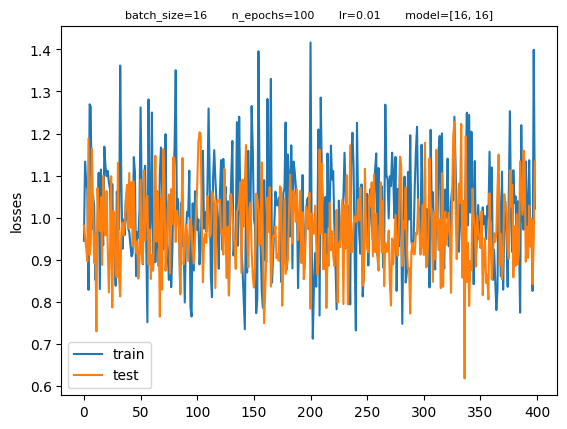

In [51]:
# print train and test loss values
plt.figure()
plt.plot(all_loss_train[1:], label='train')
plt.plot(all_loss_eval[1:], label='test')
plt.legend()
plt.ylabel('losses')
plt.title(f'batch_size={batch_size}       n_epochs={n_epochs}       lr={lr}       model={dim_hidden}', fontsize = 8)

# **8**. Visualisation des résultats

Appliquer le modèle (réseau de neurones) à une plage de `256` valeurs ordonnées qui vont de `-1.75` à `+1.75` en utilisant `torch.linspace` pour générer ces valeurs.

In [52]:
model.eval()
# ...

x_visu = torch.linspace(-1.75, 1.75, 256) # ...
y_visu = torch.zeros(0, 1)
for i in range(256//16):
    y_pred = model(x_visu[i*16:(i+1)*16].unsqueeze(1))
    y_visu = torch.cat((y_visu, y_pred), 0)
y_visu = y_visu.detach().numpy()

Afficher le résultat du réseau sous la forme d'une courbe (`plt.plot`).

Pour convertir un tenseur PyTorch `torch.Tensor` en tableau Numpy `np.ndarray` : 
- détacher le tenseur du graph de calcul de PyTorch avec `torch.Tensor.detach`
- puis convertir le tenseur détaché avec `torch.Tensor.numpy`

Text(0.5, 1.0, 'batch_size=16       n_epochs=100       lr=0.01       model=[16, 16]')

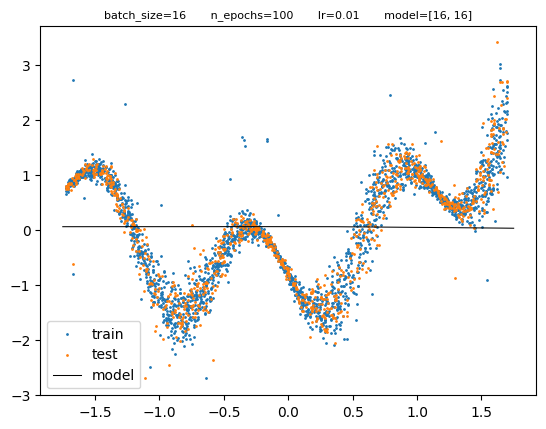

In [53]:
# plot of training and test data + visualization
plt.figure()
plt.scatter(data_train[:,0], data_train[:,1], s=1.0, label='train')
plt.scatter(data_test[:,0], data_test[:,1], s=1.0, label='test')
plt.plot(x_visu, y_visu, 'k', linewidth=0.75, label='model')
plt.legend()
plt.title(f'batch_size={batch_size}       n_epochs={n_epochs}       lr={lr}       model={dim_hidden}', fontsize = 8)

# **9**. Ajustement des hyperparamètres

Relancer l'entraînement et la visualisation des résultats en effectuant, étape-par-étape les ajustements suivants :

**Attention** : toujours relancer les cellules à partir de la création du réseau de neurones (sinon on fait de l'entraînement incrémental) !

1. Oscillation dans la loss $\Rightarrow$ diminuer le learning rate à `lr=0.01` 
2. Loss diminue toujours $\Rightarrow$ augmenter le nombre d'époques à `n_epochs = 100`
3. Peu d'amélioration $\Rightarrow$ augmenter la profondeur du réseau avec `dim_hidden = [16,16]`
4. Ou alors $\Rightarrow$ augmenter la largeur du réseau avec `dim_hidden = [128]`
5. Deep neural network $\Rightarrow$ `dim_hidden = [256,256,256,256]`

#### interpretation
Le réseau de neuronne renvoie globalement la moyenne a toutes les prédictions.  
Il n'arrive pas à apprendre, on sait pas pourquoi, même en changant les parametres (lr, dim_hidden).